In [2]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit

from keras import models
from keras.layers import Dense, Dropout


def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


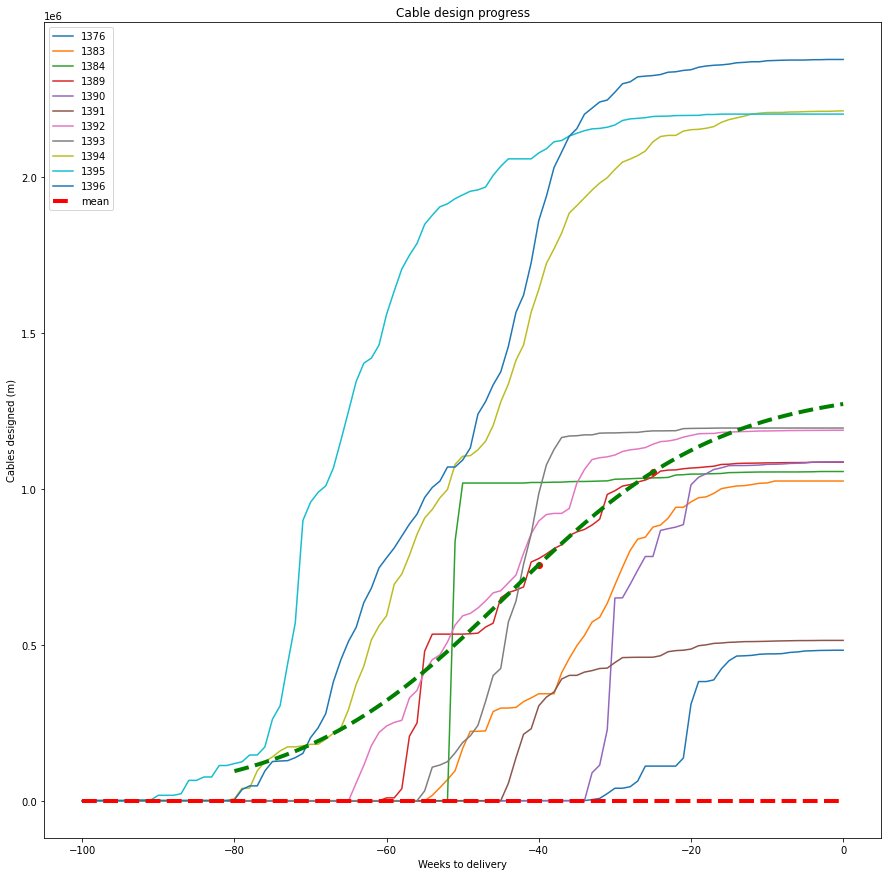

In [6]:
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall())[:, 0]
legends = []
plt.figure(figsize=(15, 15))
all = []
for ship in data:
    #if ship != 1384: continue
    cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} order by wk".format(ship))
    data = np.array(cursor.fetchall())
    x = data[:, 0]
    y = data[:, -1]
    legends.append(ship)
    ycum = y.cumsum()
    ycum_n = ycum/ycum.max(axis=0)
    #(x0hat, khat, lhat), _ = curve_fit(logifunc, x, ycum, bounds=([-100, 0, 1], [0, 10, ycum[-1]*2]))
    x2 = range(-100, 0)
    #yhat = logifunc(x2, x0hat, khat, lhat)
    if ship==1389:
        c = -40
        e = -25
        xx = x[c:e]
        yy = ycum[c:e]
        fit = np.polyfit(xx, yy, 2)
        (x0hat, khat, lhat), _ = curve_fit(logifunc, xx, yy, bounds=([-80, 0.0001, ycum[-1]*0.7], [0, 2, ycum[-1]*1.3]))

    all.append(ycum_n)
    plt.plot(x, ycum)
    #plt.plot(x2, yhat)
all = np.array(all)
ycum_n_mean = all.mean(axis=0)
legends.append('mean')
plt.plot(x, ycum_n_mean, 'r--', linewidth=4)
xx = np.linspace(-80, 0, 100)
plt.plot(xx, logifunc(xx, x0hat, khat, lhat), 'g--', linewidth=4)
plt.scatter(e, np.poly1d(fit)(e), c='r')
plt.scatter(c, np.poly1d(fit)(c), c='r')
plt.title("Cable design progress")
plt.xlabel("Weeks to delivery")
plt.ylabel("Cables designed (m)")
plt.legend(legends)
plt.savefig('cumul_progress.png')
plt.show()

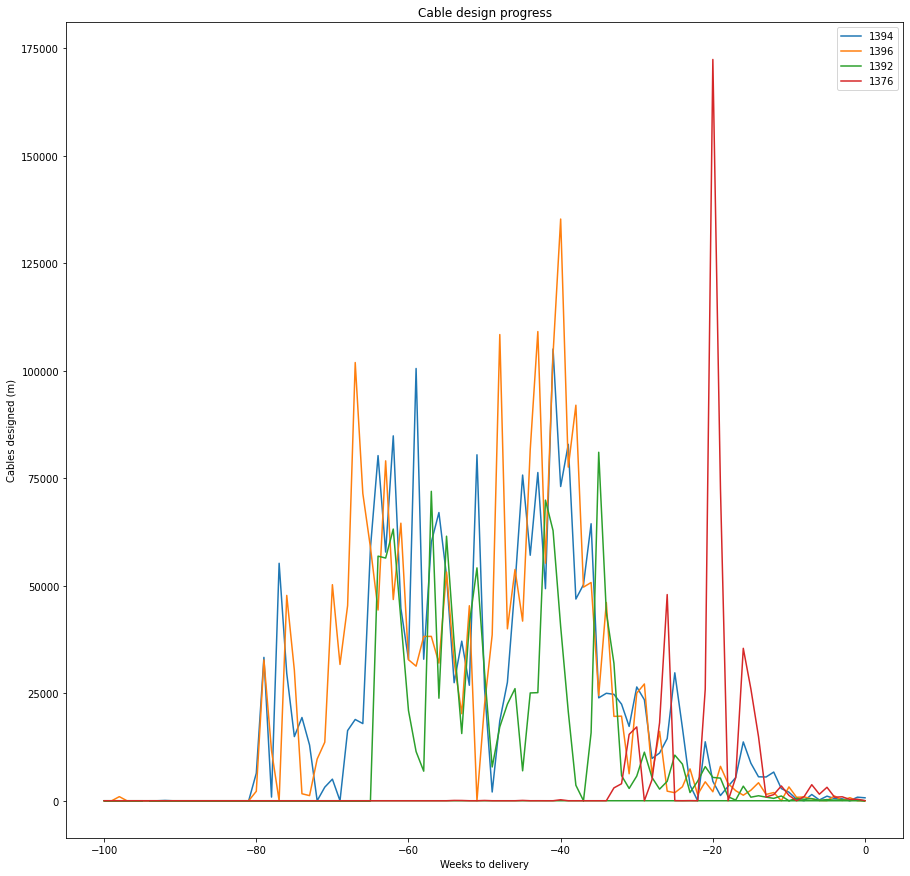

In [17]:
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall())[:, 0]
legends = []
plt.figure(figsize=(15, 15))

for ship in [1394, 1396, 1392, 1376]:#data:
    cursor.execute("SELECT wk, cables FROM progress WHERE project_id={}".format(ship))
    data = np.array(cursor.fetchall())
    x = data[:, 0]
    y = data[:, -1]
    legends.append(ship)
    plt.plot(x, y)
plt.title("Cable design progress")
plt.xlabel("Weeks to delivery")
plt.ylabel("Cables designed (m)")
plt.legend(legends)
plt.savefig('progress_interval.png')
plt.show()

98785.0
1093578.0


C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17312/4086731307.py:105: RuntimeWarning: divide by zero encountered in true_divide
  er = abs(c1-c2)**2/c2**2
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17312/4086731307.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  errors = np.array(errors)


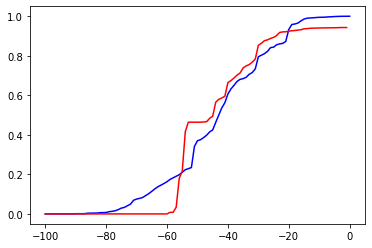

KeyboardInterrupt: Interrupted by user

In [29]:
# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]


# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()


p = 2 #ships
lpo = LeavePOut(p)


# train and evaluate
accuracies = []
accuracies2 = []
r = 0
start = -2
wk_range = 1
scale_range = 0.15
min_wk_window = 40
max_wk_window = 101
for train_i, test_i in lpo.split(ships):
    r+=1
    if r < 30:
        continue
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    all = []
    for ship in ships[train_i]:
        cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} ORDER BY wk".format(ship))
        data = np.array(cursor.fetchall())
        xx = data[:, 0]
        yy = data[:, -1]
        ycum = yy.cumsum()
        ycum_n = ycum/ycum.max(axis=0)
        all.append(ycum_n)
        #plt.plot(x, ycum_n)
    all = np.array(all)
    ycum_n_mean = all.mean(axis=0)
    for i in test_i:
        ship = ships[i]
        print(gt[i])
        linear_pred = linearModel.predict([[gt[i]]])[0]
        print(linear_pred)
        step = 5
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            wks = data.shape[0]
            xwk = data[:, 0]
            sequence = data[:, -1]/linear_pred
            sequence = sequence.cumsum()
            ses = []
            # from start to current week
            a = wks - min_wk_window
            b = max_wk_window - wks
            errors = []
            for w in range(-a, b, 1):
                if w < 0:
                    shifted_y = sequence[-w:]
                    shifted_x = xwk[-w:] + w
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                elif w > 0:
                    shifted_y = np.pad(sequence, (w, 0), 'constant', constant_values=0)
                    end = xwk[0]-w
                    shifted_x = np.pad(xwk, (w, 0), 'linear_ramp', end_values=end)
                    shifted_x += w
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                else:
                    shifted_y = sequence
                    shifted_x = xwk
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                for s in range(100-int(scale_range*100), 100+int(scale_range*100), 1):
                    scaled_shifted_y = shifted_y*(s/100)
                    c1, c2 = scaled_shifted_y, cut_y
                    ci = np.argmax(c1>0.7)
                    ti = np.argmax(c2>0.7)
                    if scaled_shifted_y[-1] <= 0.7:
                        continue
                    if ci < ti:
                        ci = ti
                    c1 = c1[ci:]
                    c2 = c2[ci:]
                    er = abs(c1-c2)**2/c2**2
                    er_avg = er.mean()
                    row = [er_avg, scaled_shifted_y, shifted_x]
                    errors.append(row)
                    continue
                    if w==0:
                        plt.plot(shifted_x, scaled_shifted_y, linewidth=5)
                    else:
                        plt.plot(shifted_x, scaled_shifted_y)
            errors = np.array(errors)
            best = np.argmin(errors[:, 0])
            [er, scaler, week] = errors[best]

            plt.plot(xx, ycum_n_mean, 'b')
            plt.plot(week, scaler, 'r')
            plt.plot()
            plt.show()
            input('pause')
            


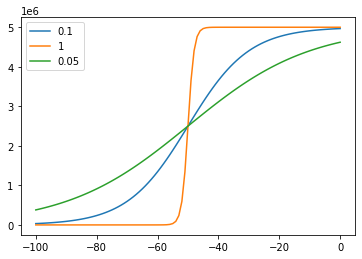

In [58]:
x = np.linspace(-100, 0, 101)
x0 = -50
kk = [0.1, 1, 0.05]
l = 5000000
for k in kk:
    plt.plot(x, logifunc(x, x0, k, l))
plt.legend(kk)
plt.show()

{3: 1, 5: 3, 7: 2, 8: 1, 9: 2, 12: 2}
1 804495
2 1073520
3 1
4 1153444
5 3
6 1336339
7 2
8 1
9 2
10 1122674
11 739800
12 2
[ 1  2  3  4  5  6  7  8  9 10 11 12]


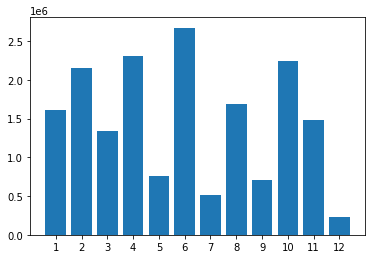

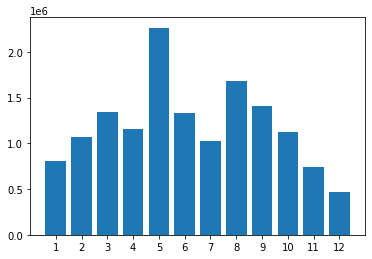

In [44]:
cursor.execute("select mth, count(*) as cnt from (select month(cast(avg(cast(planned as int)) as datetime)) as mth from routed group by project_id) t1 group by mth")
data = np.array(cursor.fetchall())
months2 = data[:, 0]
cnt = data[:, -1]
zip_iterator = zip(months2, cnt)
mth_cnt = dict(zip_iterator)
print(mth_cnt)
cursor.execute("select month(planned) as mth, sum(amount) as cables_per_mth from routed where planned is not null group by month(planned) order by mth")
data = np.array(cursor.fetchall())
months = data[:, 0]
cables = data[:, -1]
cables2 = []
for i in range(cables.shape[0]):
    #continue
    if months[i] not in mth_cnt.keys():
        cables2.append(cables[i]/(0.5))
        print(months[i], cables[i])
    else:
        div = mth_cnt[months[i]]
        print(months[i], div)
        cables2.append(cables[i]/(div))
x_pos = [i+1 for i, _ in enumerate(months)]
plt.bar(x_pos, cables2)
print(months)
plt.xticks(months)
plt.figure()
plt.bar(x_pos, cables)
plt.xticks(months)
plt.show()

In [1]:
from Constrained_GaussianProcess import ConstrainedGP
import numpy as np
m=30
# specify the constraints
constraints={'increasing': True, 'bounded': [0,1], 'convex': False}  
interval=[0,1]
Gp = ConstrainedGP(m, constraints=constraints, interval=interval)

# Training data
x_train = np.array([0.25, 0.5, 0.75])
y_train = norm().cdf((x-0.5)/0.2)

# the MCMC methods are used to approximate the posterior distribution, 
# so apart from training data, 'method' ('HMC' or 'Gibbs'), required number of samples 
# 'n' and the burn in numbers 'burn_in' should be specified when fitting the data.
Gp.fit_gp(x_train, y_train, n=100, burn_in=100, method='HMC')

x_test = np.arange(0, 1 + 0.01, 0.5)
y_pred = Gp.mean(x_test)  # get the conditional mean

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ModuleNotFoundError: No module named 'rpy2'

In [17]:
ß
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6, 7])
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_indßex, "TEST:", test_index)

TRAIN: [2 3 4] TEST: [0 1]
TRAIN: [0 1 4] TEST: [2 3]
TRAIN: [0 1 2 3] TEST: [4]


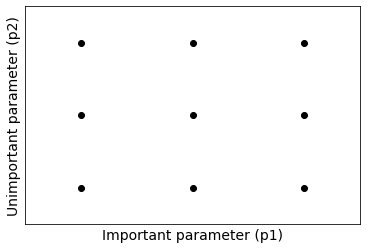

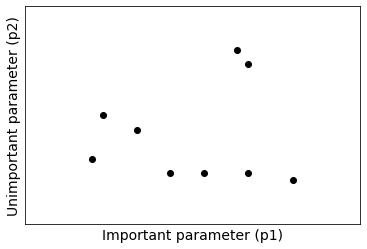

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

seed = 19
grid = np.array([1, 2, 3])
np.random.seed(seed)
rand1 = np.random.randint(10, 30, (2, 3))/10.0
np.random.seed(seed*2)
rand2 = np.random.randint(10, 30, (2, 3))/10.0
np.random.seed(seed*3)
rand3 = np.random.randint(10, 30, (2, 3))/10.0

grid_pts = itertools.product(grid, grid)

plt.figure()
plt.scatter(*zip(*grid_pts), color='k')
plt.xlim([0.5, 3.5])
plt.ylim([0.5, 3.5])
plt.xticks([])
plt.yticks([])
plt.xlabel('Important parameter (p1)')
plt.ylabel('Unimportant parameter (p2)')
plt.savefig('grid_params.png')
plt.figure()
plt.xlim([0.5, 3.5])
plt.ylim([0.5, 3.5])
plt.scatter(*rand1, color='k')
plt.scatter(*rand2, color='k')
plt.scatter(*rand3, color='k')
plt.xticks([])
plt.yticks([])
plt.xlabel('Important parameter (p1)')
plt.ylabel('Unimportant parameter (p2)')
plt.savefig('rand_params.png')
plt.show()

